In [1]:
#Here we download the libraries/frameworks that are required to execute the project
!pip3 install tensorflow==2.1.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-ahqnbdzw
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-ahqnbdzw
  Created wheel for tfutils: filename=tfutils-0.0.1-cp36-none-any.whl size=6442 sha256=4c9dd8d160527d73d299bb41761041b776738212d4e44491fcabb4c9823ab12b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0fgmwj4/wheels/fc/ae/41/9164f4ea031c0d70c13ba0d3fa9ab01c6783b36d6324db18ec
Successfully built tfutils


In [0]:
#Here we import all the libraries/frameworks that are required during the execution of the project

%matplotlib inline

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

In [3]:
#Downloading the dataset
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

#Combining the train/test images as we just need to create fake samples using noise vectors resembling true samples.
#We do not require the labels.
x = np.concatenate([x_train, x_test], axis=0)

11493376/11490434 [==============================] - 0s 0us/step


(6903, 784)


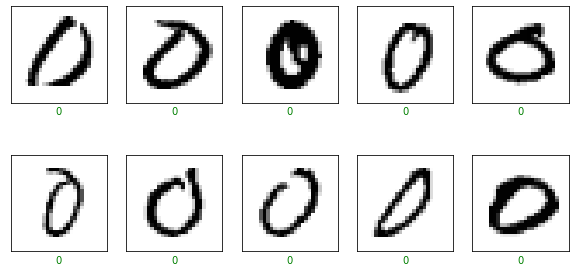

In [4]:
#printing the shape of the images.
print(x.shape)

#printing random 10 samples from the dataset.
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

In [5]:
#Here we create the dicriminator model.
#The discriminator model takes the input images and classifies them.
#The model is defined below.

size = 28
noise_dim = 1

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

In [6]:
#Here we create the generator model.
#The generator model takes the noise vector and generates the images resembling true images.
#The model is defined below.


generator = Sequential([
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

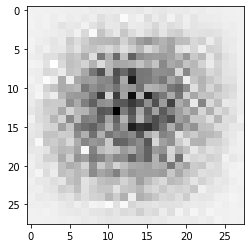

In [7]:
#Here we have showed a random noise vector.
#We can see that the image is just a random noise.
#Using such random noises we create images that resemble our images.

noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary');

In [8]:
#Compiling the whole model.
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


The total number of epochs are ::  20
Approximately 5 mins for 20 epoch....Kindly Wait
Switch to gpu in---> Runtime -> change_runtime_type -> gpu

The current epoch number is ::  1    Epoch is running..........Please Wait.........
The discriminator accuracy is :: 0.50
The generator loss is :: 2.07

The current epoch number is ::  2    Epoch is running..........Please Wait.........
The discriminator accuracy is :: 0.50
The generator loss is :: 0.02

The current epoch number is ::  3    Epoch is running..........Please Wait.........
The discriminator accuracy is :: 0.61
The generator loss is :: 0.00

The current epoch number is ::  4    Epoch is running..........Please Wait.........
The discriminator accuracy is :: 0.84
The generator loss is :: 0.00

The current epoch number is ::  5    Epoch is running..........Please Wait.........
The discriminator accuracy is :: 0.99
The generator loss is :: 8.42

The current epoch number is ::  6    Epoch is running..........Please Wait.........
The 

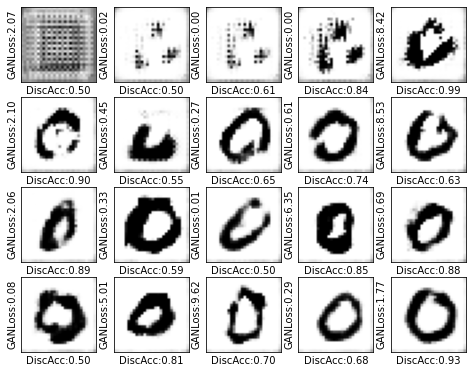

In [9]:
#Here we train our model.
#At the end of the training, we can see that images resembling our true image is generated.
#The images at the end of the results are output of each epoch.
#Thus we have 20 epochs and 20 images corresponding to it.

%%time

epochs = 20
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('The total number of epochs are :: ', epochs)
print('Approximately 5 mins for 20 epoch....Kindly Wait')
print('Switch to gpu in---> Runtime -> change_runtime_type -> gpu')


dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    print('')
    print('The current epoch number is :: ', e+1, '   Epoch is running..........Please Wait.........')

    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    print('The discriminator accuracy is :: {:.2f}'.format(acc)) 
    print('The generator loss is :: {:.2f}'.format(loss))

    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))